## 1. Data Munging

### Preliminary setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import urllib
import json
import pandas as pd

In [7]:
# Pandas config
pd.options.display.max_rows = 1600
pd.options.display.max_columns = 50

# Pyplot config
plt.rcParams.update({'font.size': 14})

In [14]:
# NHL season data
start_year = 2016
end_year = 2020
all_years = range(start_year, end_year, 1)
seasons = ['{}{}'.format(year, year+1) for year in all_years]

# Cup winners
cup_winners = pd.read_csv('cup-winners.csv', names=['year', 'team', 'abbr'])
#cup_winners.loc[3] = ['2020', 'To Be Determined', 'TBD']
#cup_winners.index = seasons

ValueError: Length mismatch: Expected axis has 102 elements, new values have 4 elements

### Clean build for current season

In [15]:
### THIS IS A CLEAN BUILD FOR THE CURRENT SEASON, JUST A TEMPLATE ###

teams_req = urllib.request.urlopen('https://statsapi.web.nhl.com/api/v1/teams?expand=team.stats')
teams_json = teams_req.read().decode()
teams_meta = dict(json.loads(teams_json))
teams_dict = {key['abbreviation']:key for key in teams_meta['teams']}
teams_df = pd.DataFrame.from_dict(teams_dict)

stats_dict = {team:teams_df[team]['teamStats'][0]['splits'][0]['stat'] for team in teams_df.columns}
stats_df = pd.DataFrame.from_dict(stats_dict, orient='index')

### Pulling and building for all seasons

In [16]:
# Pull data for all seasons from NHL API
teams_reqs = [urllib.request.urlopen( \
              'https://statsapi.web.nhl.com/api/v1/teams?expand=team.stats&season={}'.format( \
              season)) for season in seasons]

In [17]:
# Decode into readable JSON-like format
teams_jsons = [req.read().decode() for req in teams_reqs]

In [18]:
# Load in as JSON and collect appropriate segments into dictionary
teams_metas = [dict(json.loads(fread))['teams'] for fread in teams_jsons]

In [19]:
# Create list of all team data for each season
teams_dicts = [{key['abbreviation']:key for key in season} for season in teams_metas]

In [20]:
# Create master dictionary for all teams for each season
season_dict = dict(zip(seasons, teams_dicts))

In [21]:
# Create stats dictionary
stats_dict = {}

for key in season_dict:
    # Some seasons have no stats available, NaN results in KeyError
    try:
        stats_dict[key] = {season_dict[key][team]['abbreviation'] : \
                       season_dict[key][team]['teamStats'][0]['splits'][0]['stat'] \
                       for team in season_dict[key]}
    except KeyError:
    # Populate teams one at a time in years where some teams have no stats
        stats_dict[key] = {}
        for team in season_dict[key]:
            try:
                stats_dict[key][team] = season_dict[key][team]['teamStats'][0]['splits'][0]['stat']
            except KeyError:
                # Empty dictionary for teams with no stats (rather than NaN)
                stats_dict[key][team] = {key:0 for key in season_dict['20002001']['COL']['teamStats'][0]['splits'][0]['stat']}

In [22]:
# Create master dictionary of seasonal stats dataframes for each season
stats_dfs = {key:pd.DataFrame.from_dict(stats_dict[key], orient='index') for key in stats_dict}

In [165]:
# Append a new boolean array column to each seasonal dataframe to indicate Stanley Cup winner
for key in stats_dfs:
    win_bool = stats_dfs[key].index == cup_winners.loc[key]['abbr']
    stats_dfs[key]['cupWin'] = win_bool

### Exploring the data

In [24]:
# Try a test year to investigate, get relevant data
test_df = stats_dfs['20162017']
stat_cols = test_df.columns
years = cup_winners['year']

In [32]:
stats_df

,shotsAllowed,shotsPerGame,faceOffWinPercentage,ot,winOutshotByOpp,shootingPctg,ptPctg,savePctg,faceOffsWon,faceOffsLost,winOutshootOpp,evGGARatio,winLeadSecondPer,powerPlayOpportunities,penaltyKillPercentage,faceOffsTaken,powerPlayGoals,losses,powerPlayGoalsAgainst,wins,goalsAgainstPerGame,winOppScoreFirst,gamesPlayed,winScoreFirst,pts,powerPlayPercentage,goalsPerGame,winLeadFirstPer
ANA,32.9512,30.7561,49.6,7,0.455,9.3,54.9,0.913,1131.0,1147.0,0.500,0.8929,0.813,108.0,84.8,2278.0,28.0,15,17.0,19,2.854,0.235,41,0.625,45,25.9,2.854,0.800
ARI,33.8108,26.2703,48.3,4,0.290,8.4,29.7,0.891,985.0,1054.0,0.000,0.6966,1.000,101.0,73.4,2039.0,13.0,24,34.0,9,3.676,0.130,37,0.429,22,12.9,2.216,0.500
BOS,29.1143,36.0286,53.8,2,0.714,8.7,65.7,0.913,1145.0,985.0,0.607,1.1613,0.941,105.0,83.2,2130.0,25.0,11,19.0,22,2.543,0.467,35,0.750,46,23.8,3.143,1.000
BUF,34.4359,28.9231,46.1,7,0.292,8.8,39.7,0.901,959.0,1120.0,0.333,0.7778,0.533,103.0,78.2,2079.0,19.0,20,22.0,12,3.410,0.143,39,0.500,31,18.4,2.538,0.500
CAR,27.7714,33.4571,54.6,2,0.727,10.2,74.3,0.918,1134.0,944.0,0.727,1.4483,0.889,107.0,90.5,2078.0,26.0,8,12.0,25,2.286,0.563,35,0.842,52,24.3,3.400,0.933
CBJ,34.7778,29.4722,50.0,1,0.400,10.7,48.6,0.896,1010.0,1010.0,0.636,0.8421,0.700,93.0,78.0,2020.0,15.0,18,22.0,17,3.611,0.421,36,0.529,35,16.1,3.139,0.556
CGY,30.0882,34.9412,49.9,6,0.455,8.7,58.8,0.915,983.0,986.0,0.522,1.1552,0.938,99.0,84.2,1969.0,21.0,11,16.0,17,2.559,0.286,34,0.650,40,21.2,3.029,0.750
CHI,31.7949,28.1282,49.2,6,0.308,8.4,46.2,0.899,998.0,1032.0,0.500,0.7179,0.750,128.0,76.3,2030.0,24.0,18,27.0,15,3.205,0.190,39,0.611,36,18.8,2.359,0.625
COL,30.5000,35.1667,47.2,3,0.333,12.1,73.6,0.895,1018.0,1138.0,0.875,1.3472,0.905,140.0,74.1,2156.0,33.0,8,28.0,25,3.194,0.438,36,0.900,53,23.6,4.250,1.000
DAL,30.7714,29.6000,54.6,2,0.471,9.4,54.3,0.903,1108.0,920.0,0.500,0.9077,0.786,98.0,77.6,2028.0,25.0,15,24.0,18,3.000,0.231,35,0.682,38,25.5,2.771,0.867


ValueError: x and y must be the same size

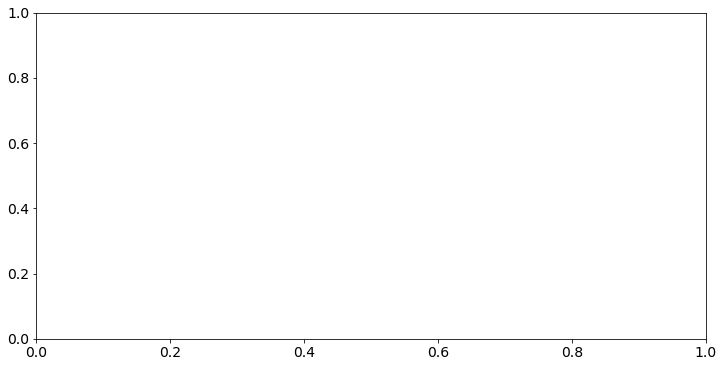

In [25]:
# Collect, e.g., the goals per game over time and plot against average
gpg = [np.mean(stats_dfs[key]['goalsPerGame']) for key in stats_dfs]
plt.figure(figsize=(12, 6))
plt.scatter(years, gpg)
plt.ylim(-0.1, 6)
plt.title('Goals per game over time against historical average')
plt.xlabel('Season')
plt.ylabel('GPG')
plt.axhline(np.mean(gpg), label='Average goals per game, all time')
plt.tight_layout()
plt.legend()

In [1083]:
# Scaling the data to explore statistical trends
from sklearn import preprocessing

scaler_mm = preprocessing.MinMaxScaler(feature_range=(-1, 1))
scaler_mm.fit(test_df_mns)

MinMaxScaler(copy=True, feature_range=(-1, 1))

In [1066]:
# Creating a mean-subtracted, normalized dataframe
for column in test_df.columns:
    if type(test_df[column][0]) is str:
        test_df[column] = test_df[column].astype(float)
        
test_df_mns = test_df - test_df.mean()
test_df_scaled = scaler_mm.transform(test_df_mns)

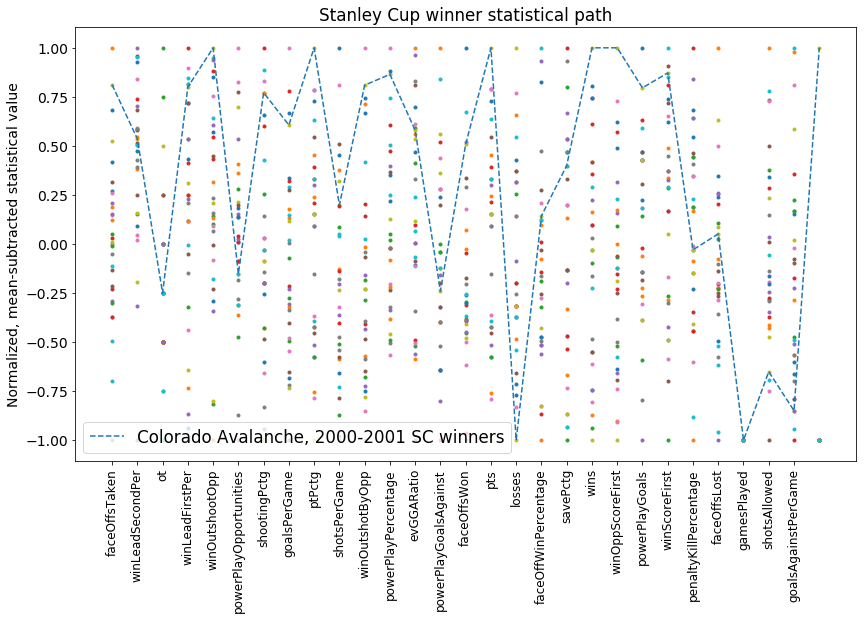

In [1113]:
# Scatter-plotting all team's statistics to set the winner's against
plt.figure(figsize=(14, 8))

for ind, arr in enumerate(test_df_scaled):
    if ind == test_df.index.get_loc('COL'):
        plt.plot(np.arange(len(stat_cols)), arr, linestyle='--', label='Colorado Avalanche, 2000-2001 SC winners')
        plt.scatter(np.arange(len(stat_cols)), arr, marker='.')
    else:
        plt.scatter(np.arange(len(stat_cols)), arr, marker='.')
    
plt.title('Stanley Cup winner statistical path')
plt.xticks(np.arange(len(stat_cols[:-1])), stat_cols[:-1], rotation=90)
plt.rc('xtick', labelsize=12)
plt.ylabel('Normalized, mean-subtracted statistical value')
plt.legend(loc=0, fontsize='large')

### Preparing data for ML

In [127]:
# 9th year of recording NHL stats is when Stanley Cup became exclusive to NHL
dfs_for_merge = [stats_dfs[season] for season in seasons[9:-1]]

# Create master dataframe containing all inputs and outputs
merger = pd.concat(dfs_for_merge, sort=False)

# Create the input and target vectors for classification
inputs = merger.drop('cupWin', axis='columns')
target = merger['cupWin']

## 2. Random Forest Classification

### Setup

In [1032]:
import itertools

from matplotlib import cm
from sklearn import model_selection as md
from sklearn import preprocessing

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

### Naive first attempt

In [365]:
# Create the training and validation sets
inp_train, inp_validate, tar_train, tar_validate = train_test_split(inputs, target, test_size=0.2, random_state=0)

In [366]:
# Build the classifier
RFclass = RandomForestClassifier(n_estimators=100, criterion='entropy',
                              max_depth=100,
                              min_samples_leaf=10,
                              max_features='auto', max_leaf_nodes=None,
                              min_impurity_decrease=0.0,
                              min_impurity_split=None,
                              bootstrap=True,
                              n_jobs=None, 
                              verbose=0)

In [420]:
# Fit the data as is
rf_naive = RFclass.fit(inp_train, tar_train)

In [422]:
# Make some predictions
pred_train = rf_naive.predict(inp_train)
prob_train = rf_naive.predict_proba(inp_train)
pred_val = rf_naive.predict(inp_validate)
prob_val = rf_naive.predict_proba(inp_validate)

### Analysis

In [890]:
# Define a custom confusion matrix to investigate the results
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        plt.suptitle('Normalized Confusion Matrices')
    else:
        plt.suptitle('Confusion Matrices')
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes, rotation=45)
    plt.yticks(ticks, classes)
    fmt = '.2f' if normalize else 'd'
    threshold = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', 
                 color='white' if cm[i,j] > threshold else 'black')
        
    #plt.tight_layout()
    plt.ylabel('Actual Result')
    plt.xlabel('Predicted Result')

In [891]:
# Create the confusion matrices
cnf_matrix_tr = confusion_matrix(tar_train, pred_train)
cnf_matrix_va = confusion_matrix(tar_validate, pred_val)

[]

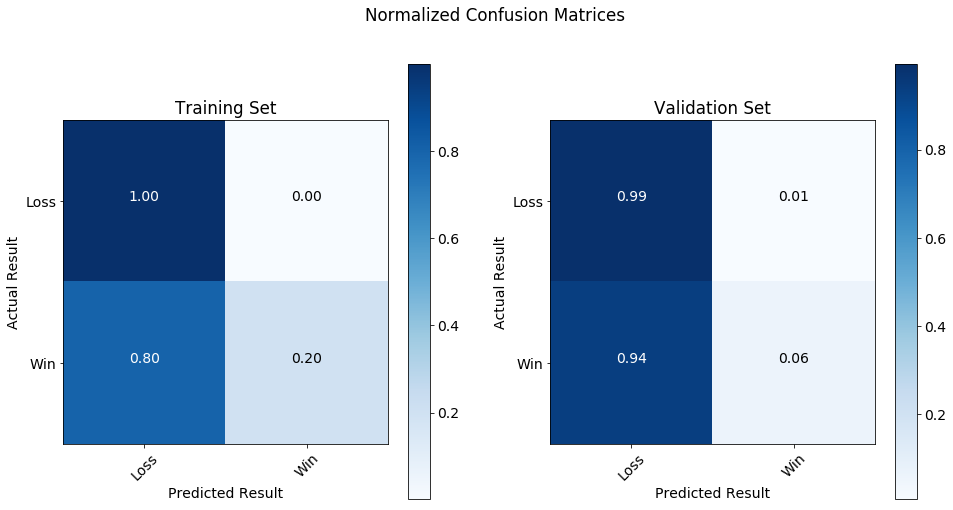

In [893]:
# Plot the confusion matrices
plt.figure(figsize=(16,8))

plt.subplot(121)

plot_confusion_matrix(cnf_matrix_tr, classes=['Loss', 'Win'], normalize=True,
                      title='Training Set')

plt.plot(legend=None)

plt.subplot(122)

plot_confusion_matrix(cnf_matrix_va, classes=['Loss', 'Win'], normalize=True,
                      title='Validation Set')

plt.plot(legend=None)

### Tweaking and scaling

In [1128]:
# Build the classifier with more estimators, try other criterion this time
RFclass = RandomForestClassifier(n_estimators=300, criterion='gini',
                              min_samples_leaf=10,
                              min_impurity_split=None,
                              bootstrap=True,
                              n_jobs=None, 
                              verbose=0)

In [1129]:
# Scale the data in a few different ways
scaler_s = preprocessing.StandardScaler().fit(inp_train)
scaler_m = preprocessing.MinMaxScaler().fit(inp_train)
scaler_r = preprocessing.RobustScaler().fit(inp_train)

inp_tr_s_scale = scaler_s.transform(inp_train) 
inp_va_s_scale = scaler_s.transform(inp_validate)

inp_tr_m_scale = scaler_m.transform(inp_train) 
inp_va_m_scale = scaler_m.transform(inp_validate)

inp_tr_r_scale = scaler_r.transform(inp_train) 
inp_va_r_scale = scaler_r.transform(inp_validate)

In [1130]:
# Fit the scaled data
rf_scaled_s = RFclass.fit(inp_tr_s_scale, tar_train)
rf_scaled_m = RFclass.fit(inp_tr_m_scale, tar_train)
rf_scaled_r = RFclass.fit(inp_tr_r_scale, tar_train)

In [1131]:
# Make some predictions
pred_train_s = rf_scaled_s.predict(inp_tr_s_scale)
prob_train_s = rf_scaled_s.predict_proba(inp_tr_s_scale)
pred_val_s = rf_scaled_s.predict(inp_va_s_scale)
prob_val_s = rf_scaled_s.predict_proba(inp_va_s_scale)

pred_train_m = rf_scaled_m.predict(inp_tr_m_scale)
prob_train_m = rf_scaled_m.predict_proba(inp_tr_m_scale)
pred_val_m = rf_scaled_m.predict(inp_va_m_scale)
prob_val_m = rf_scaled_m.predict_proba(inp_va_m_scale)

pred_train_r = rf_scaled_m.predict(inp_tr_r_scale)
prob_train_r = rf_scaled_m.predict_proba(inp_tr_r_scale)
pred_val_r = rf_scaled_m.predict(inp_va_r_scale)
prob_val_r = rf_scaled_m.predict_proba(inp_va_r_scale)

In [1132]:
# Create the confusion matrices
cnf_matrix_s_tr = confusion_matrix(tar_train, pred_train_s)
cnf_matrix_m_tr = confusion_matrix(tar_train, pred_train_m)
cnf_matrix_r_tr = confusion_matrix(tar_train, pred_train_r)

cnf_matrix_s_va = confusion_matrix(tar_validate, pred_val_s)
cnf_matrix_m_va = confusion_matrix(tar_validate, pred_val_m)
cnf_matrix_r_va = confusion_matrix(tar_validate, pred_val_r)

[]

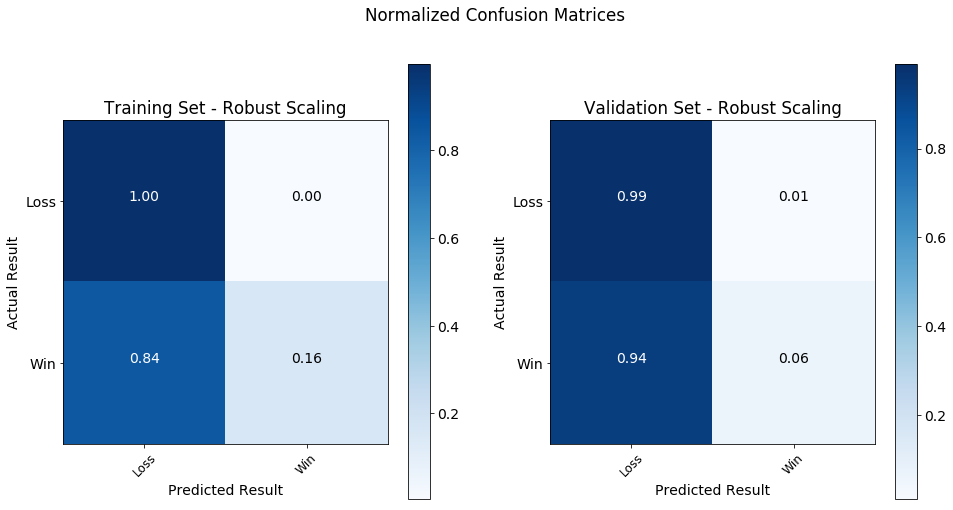

In [1133]:
# Plot the confusion matrices
plt.figure(figsize=(16,8))

plt.subplot(121)
plot_confusion_matrix(cnf_matrix_s_tr, classes=['Loss', 'Win'], normalize=True,
                      title='Training Set - Robust Scaling')
plt.plot(legend=None)

plt.subplot(122)
plot_confusion_matrix(cnf_matrix_s_va, classes=['Loss', 'Win'], normalize=True,
                      title='Validation Set - Robust Scaling')
plt.plot(legend=None)

[]

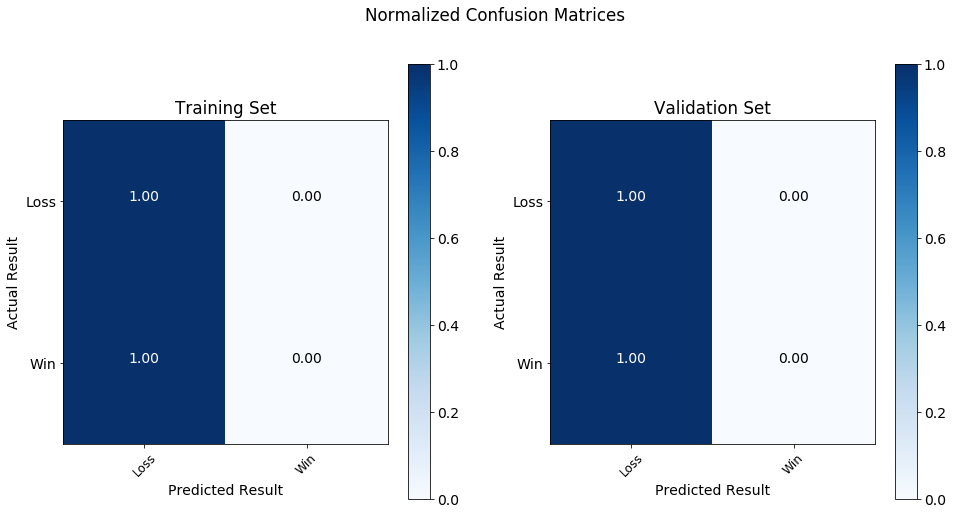

In [1120]:
# Plot the confusion matrices
plt.figure(figsize=(16,8))

plt.subplot(121)
plot_confusion_matrix(cnf_matrix_m_tr, classes=['Loss', 'Win'], normalize=True,
                      title='Training Set - MinMax Scaling')
plt.plot(legend=None)

plt.subplot(122)
plot_confusion_matrix(cnf_matrix_m_va, classes=['Loss', 'Win'], normalize=True,
                      title='Validation Set - MinMax Scaling')
plt.plot(legend=None)

[]

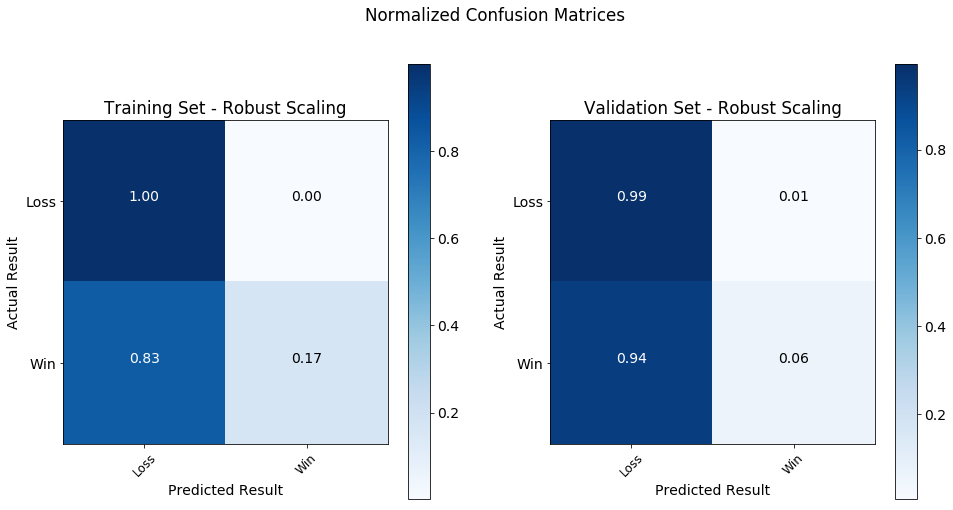

In [924]:
# Plot the confusion matrices
plt.figure(figsize=(16,8))

plt.subplot(121)
plot_confusion_matrix(cnf_matrix_r_tr, classes=['Loss', 'Win'], normalize=True,
                      title='Training Set - Robust Scaling')
plt.plot(legend=None)

plt.subplot(122)
plot_confusion_matrix(cnf_matrix_r_va, classes=['Loss', 'Win'], normalize=True,
                      title='Validation Set - Robust Scaling')
plt.plot(legend=None)

In [1039]:
# Do an AUC/ROC analysis
ohe = OneHotEncoder(sparse=False)
tar = np.reshape(tar_validate.values, (-1, 1))
tar = ohe.fit_transform(tar)

Text(0.5, 1.0, 'Area Under the Curve = 0.209')

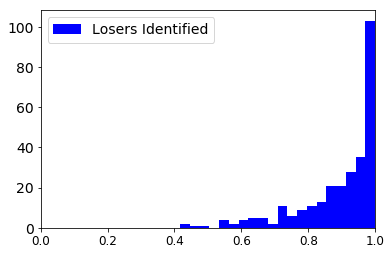

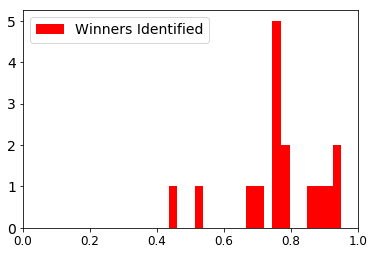

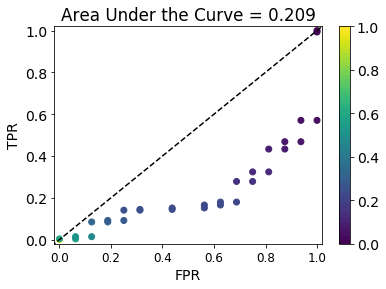

In [1048]:
# Plot curves and ROC
plt.figure(1)
plt.hist(prob_val_s[tar_validate==0,0],20,color = "blue",)
plt.xlim([0,1])
plt.legend(['Losers Identified'])

plt.figure(2)
plt.hist(prob_val_s[tar_validate==1,0],20,color = "red",)
plt.xlim([0,1])
plt.legend(['Winners Identified'])

fpr = dict()
tpr = dict()
T=dict()
roc_auc = dict()

for i in range(2):
    tpr[i], fpr[i], T[i] = roc_curve(tar[:, i], prob_val_s[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(3)

cmap = cm.get_cmap("viridis",50)
plt.scatter(fpr[1], tpr[1], c=T[1],cmap=cmap,vmin=0.,vmax=1)
plt.colorbar()
plt.plot([-0.2,1.2],[-0.2,1.2], '--k')
plt.xlim([-.02,1.02])
plt.ylim([-.02,1.02])

plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Area Under the Curve = %.3f' %roc_auc[0])

Text(0.5, 1.0, 'Input Feature Importance')

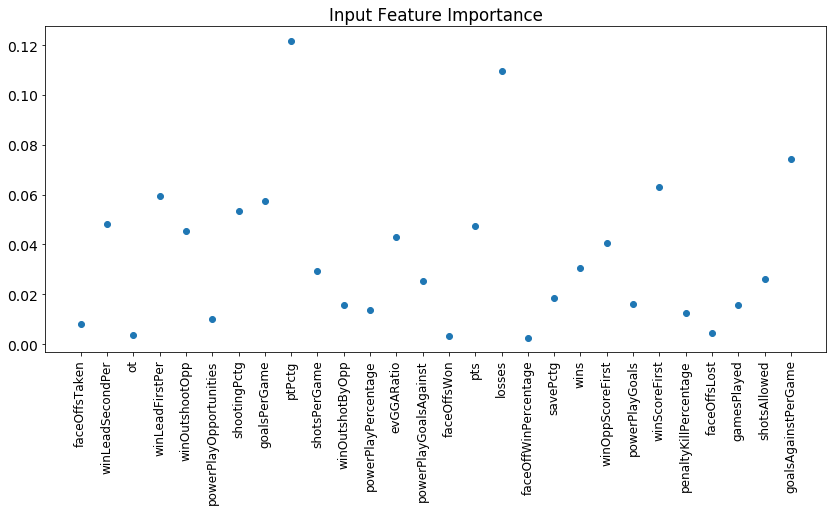

In [925]:
# Plot the input feature importance
h1 = rf_scaled_r.feature_importances_
plt.figure(figsize=(14, 6))
plt.plot(h1,'o')
plt.xticks(np.arange(len(stat_cols[:-1])), stat_cols[:-1], rotation=90)
plt.rc('xtick', labelsize=12)
plt.title('Input Feature Importance')

## 4. KNN Classification

In [962]:
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier

In [938]:
knn = KNeighborsClassifier(n_neighbors=6)

In [939]:
knn.fit(inp_tr_s_scale, tar_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                     weights='uniform')

In [1013]:
tscore = knn.score(inp_tr_s_scale, tar_train)
vscore = knn.score(inp_va_s_scale, tar_validate)
print('KNN training score: ' + str(tscore))
print('KNN validation score: ' + str(vscore))

KNN training score: 0.9406850459482038
KNN validation score: 0.94


In [941]:
knn_pred_train = knn.predict(inp_tr_s_scale)
knn_prob_train = knn.predict_proba(inp_tr_s_scale)

knn_pred_va = knn.predict(inp_va_s_scale)
knn_prob_va = knn.predict_proba(inp_va_s_scale)

In [942]:
cnf_matrix_knn_tr = confusion_matrix(knn_pred_train, tar_train)
cnf_matrix_knn_va = confusion_matrix(knn_pred_va, tar_validate)

[]

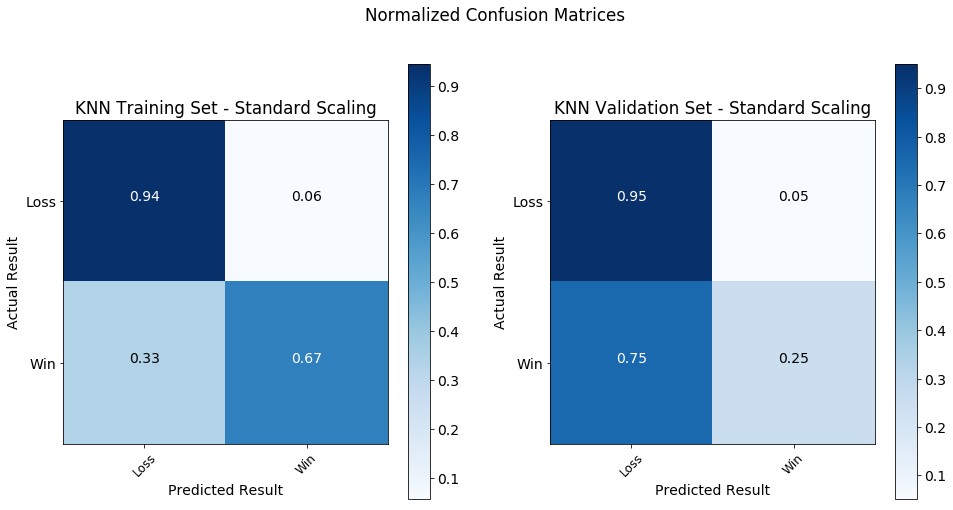

In [944]:
# Plot the confusion matrices
plt.figure(figsize=(16,8))

plt.subplot(121)
plot_confusion_matrix(cnf_matrix_knn_tr, classes=['Loss', 'Win'], normalize=True,
                      title='KNN Training Set')
plt.plot(legend=None)

plt.subplot(122)
plot_confusion_matrix(cnf_matrix_knn_va, classes=['Loss', 'Win'], normalize=True,
                      title='KNN Validation Set')
plt.plot(legend=None)

### PCA

In [1003]:
# First impute the 0-values from the early seasons
imp_mean = SimpleImputer(missing_values=0.0, strategy='mean')
imp_mean.fit(inp_tr_s_scale)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=0.0, strategy='mean', verbose=0)

In [1005]:
# Transform the data with the imputer
imp_inp_tr = imp_mean.transform(inp_tr_s_scale)
imp_inp_va = imp_mean.transform(inp_va_s_scale)

In [1006]:
# Now do PCA to half the number of input features
n_components = int(len(stat_cols)/2)
pca = PCA(n_components=n_components)

pca.fit(imp_inp_tr)
inp_tr_pca = pca.transform(imp_inp_tr)
inp_va_pca = pca.transform(imp_inp_va)

In [1007]:
# Make a new KNN classifier for the PCA data
knn_pca = KNeighborsClassifier(n_neighbors=6)

In [1008]:
knn_pca.fit(inp_tr_pca, tar_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                     weights='uniform')

In [1009]:
knn_pca_train = knn_pca.predict(inp_tr_pca)
knn_pca_train_prob = knn_pca.predict_proba(inp_tr_pca)

knn_pca_val = knn_pca.predict(inp_va_pca)
knn_pca_val = knn_pca.predict_proba(inp_va_pca)

In [1010]:
cnf_matrix_pca_train = confusion_matrix(knn_pca_train, tar_train)
cnf_matrix_pca_val = confusion_matrix(knn_pca_pred, tar_validate)

[]

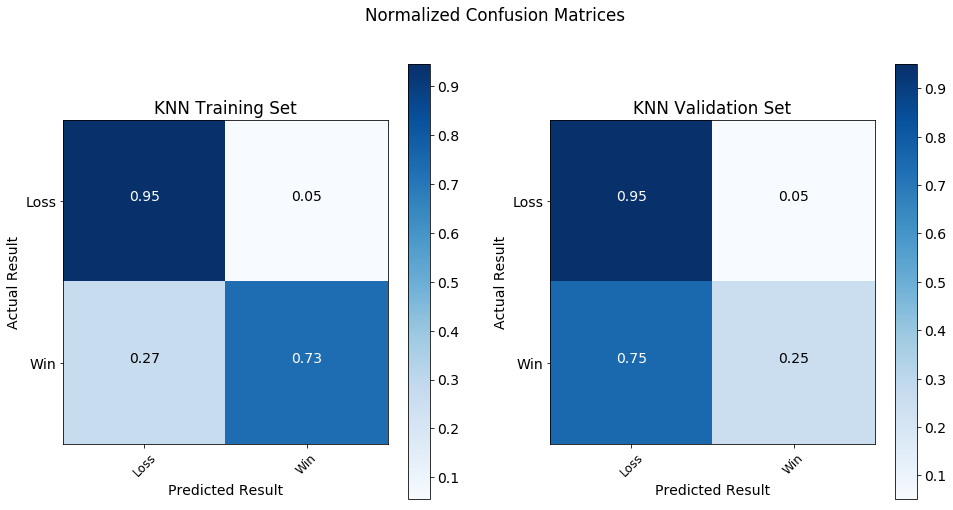

In [1011]:
# Plot the confusion matrices
plt.figure(figsize=(16,8))

plt.subplot(121)
plot_confusion_matrix(cnf_matrix_pca_train, classes=['Loss', 'Win'], normalize=True,
                      title='KNN Training Set')
plt.plot(legend=None)

plt.subplot(122)
plot_confusion_matrix(cnf_matrix_pca_val, classes=['Loss', 'Win'], normalize=True,
                      title='KNN Validation Set')
plt.plot(legend=None)

In [1114]:
test_df

,faceOffsTaken,winLeadSecondPer,ot,winLeadFirstPer,winOutshootOpp,powerPlayOpportunities,shootingPctg,goalsPerGame,ptPctg,shotsPerGame,winOutshotByOpp,powerPlayPercentage,evGGARatio,powerPlayGoalsAgainst,faceOffsWon,pts,losses,faceOffWinPercentage,savePctg,wins,winOppScoreFirst,powerPlayGoals,winScoreFirst,penaltyKillPercentage,faceOffsLost,gamesPlayed,shotsAllowed,goalsAgainstPerGame,cupWin
ANA,5520.0,0.750,5,0.435,0.355,373.0,8.9,2.293,40.2,25.8902,0.280,17.7,0.9206,71.0,2668.0,66,41,48.3,0.899,25,0.156,66.0,0.486,81.8,2852.0,82,29.4756,2.988,False
ATL,5711.0,0.864,2,0.480,0.200,395.0,9.2,2.573,36.6,27.9390,0.321,13.7,0.7380,90.0,2631.0,60,45,46.1,0.891,23,0.104,54.0,0.529,77.9,3080.0,82,32.3780,3.524,False
BOS,5398.0,0.862,8,0.760,0.449,390.0,9.6,2.768,53.7,28.7683,0.387,16.4,1.1898,65.0,2658.0,88,30,49.2,0.886,36,0.267,64.0,0.649,82.8,2740.0,82,26.7195,3.037,False
BUF,5306.0,0.947,1,0.862,0.610,373.0,9.9,2.659,59.8,26.8780,0.500,16.1,0.9645,40.0,2653.0,98,30,50.0,0.916,46,0.250,60.0,0.760,88.0,2653.0,82,26.7683,2.244,False
CAR,5286.0,0.889,3,0.692,0.550,382.0,9.6,2.585,53.7,27.0366,0.417,18.9,0.9645,45.0,2904.0,88,32,54.9,0.898,38,0.310,72.0,0.625,87.2,2382.0,82,26.9024,2.744,False
CBJ,5338.0,0.786,6,0.630,0.417,381.0,9.1,2.317,43.3,25.3902,0.304,14.7,0.5780,70.0,2695.0,71,39,50.5,0.906,28,0.231,56.0,0.442,80.7,2643.0,82,30.1829,2.841,False
CGY,5431.0,0.733,4,0.667,0.400,435.0,8.8,2.402,44.5,27.1951,0.256,14.9,0.9197,76.0,2800.0,73,36,51.6,0.894,27,0.136,65.0,0.553,79.9,2631.0,82,27.1220,2.878,False
CHI,5382.0,0.826,5,0.609,0.432,318.0,9.7,2.561,43.3,26.3415,0.317,12.9,1.0889,52.0,2686.0,71,40,49.9,0.888,29,0.205,41.0,0.526,83.9,2696.0,82,26.7073,3.000,False
COL,5649.0,0.851,4,0.818,0.636,363.0,11.3,3.293,72.0,29.2073,0.640,22.0,1.1852,59.0,2900.0,118,16,51.3,0.907,52,0.474,80.0,0.773,82.8,2749.0,82,25.1098,2.341,True
DAL,5152.0,0.946,2,0.828,0.625,367.0,11.5,2.939,64.6,25.6098,0.550,19.6,1.0547,49.0,2636.0,106,24,51.2,0.908,48,0.324,72.0,0.800,86.2,2516.0,82,24.9146,2.280,False


In [1115]:
len(test_df.loc['COL'])

29

In [1118]:
test_df.loc['COL']

faceOffsTaken                5649
winLeadSecondPer            0.851
ot                              4
winLeadFirstPer             0.818
winOutshootOpp              0.636
powerPlayOpportunities        363
shootingPctg                 11.3
goalsPerGame                3.293
ptPctg                         72
shotsPerGame              29.2073
winOutshotByOpp              0.64
powerPlayPercentage            22
evGGARatio                 1.1852
powerPlayGoalsAgainst          59
faceOffsWon                  2900
pts                           118
losses                         16
faceOffWinPercentage         51.3
savePctg                    0.907
wins                           52
winOppScoreFirst            0.474
powerPlayGoals                 80
winScoreFirst               0.773
penaltyKillPercentage        82.8
faceOffsLost                 2749
gamesPlayed                    82
shotsAllowed              25.1098
goalsAgainstPerGame         2.341
cupWin                       True
Name: COL, dty